# Depth Prediction Example with P2Net

In [19]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "stereonet")
sys.path.append(wd)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from models import StereoNet
from dataset import DepthEstDataset

In [21]:
model_name = "stereonet"
max_disp = 192
stages = 4  # related to the downsampling factor to get the coarse cost volume

### Load model from checkpoint
It seems that the model pretrained with multiple GPUs since it needs nn.DataParallel to properly load the pretrained model. Therefore, as least 1 GPU is required to run this demo

In [22]:
model = StereoNet(k=stages-1, r=stages-1, maxdisp=max_disp)
model = nn.DataParallel(model).cuda()

In [23]:
checkpt_path = os.path.join(wd, "checkpts", "checkpoint_pretrain_secneflow.pth")
checkpt = torch.load(checkpt_path)
model.load_state_dict(checkpt['state_dict'])
print("Loaded pretrained model")

Loaded pretrained model


### Predict depth from input images

In [32]:
depth_dataset = DepthEstDataset(model_name)
test_loader = DataLoader(depth_dataset, batch_size=1, shuffle=True)

In [33]:
with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        left_im, right_im, pred_disp_path = inputs
        left_im = left_im.cuda()
        right_im = right_im.cuda()
        
        outputs = model(left_im, right_im)
        pred_disp = outputs[1].detach().cpu().numpy()
        pred_disp = np.squeeze(pred_disp)
        
        np.save(pred_disp_path[0], pred_disp)

### Print a sample image and its predicted depth

In [34]:
left_im = torch.squeeze(left_im)
left_im = left_im.detach().cpu()
left_im = transforms.ToPILImage()(left_im)

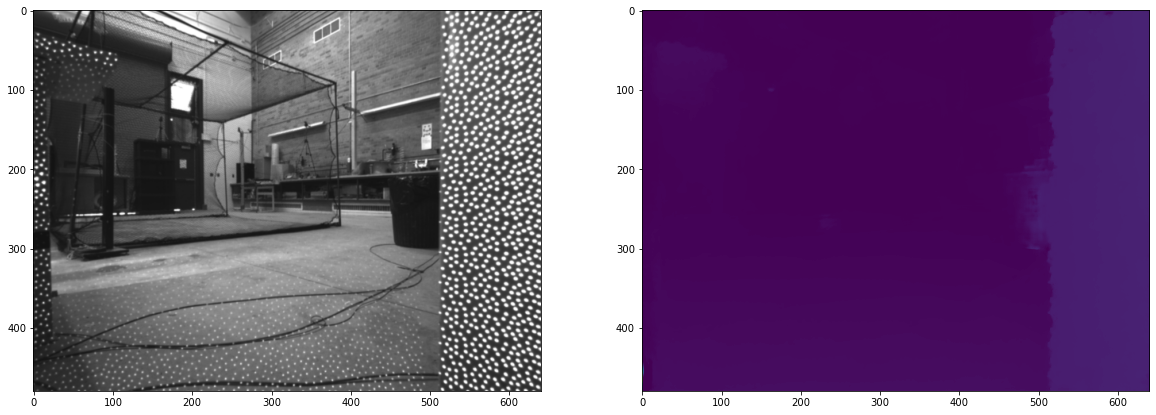

In [35]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)

pred_disp_for_plot = np.copy(pred_disp)
pred_disp_for_plot[pred_disp_for_plot>max_disp] = 0  # remove some outliers
pred_disp_for_plot = pred_disp / np.amax(pred_disp_for_plot)
plt.imshow(pred_disp_for_plot)